# Will I get into University?

In this notebook, we ask a simple question:
> My SAT scores are X for the language and Y for the math portions. It's X + Y total. What are my chances in going to any University?

Given 2 components of the **SAT scores**, can we find out if a student is able to go to college? Let's find out.

First, install the necessary python packages. We will need:
* numpy
* tensorflow
* matplotlib
* pandas
* scikit-learn

In [116]:
pip install numpy tensorflow matplotlib pandas scikit-learn --user

Note: you may need to restart the kernel to use updated packages.


Now, we will import the packages to be used for the rest of the notebook.

We will also set the `seed` of Tensorflow to be `7` so that we can get some sort of reproducible result.

In [117]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import random

tf.random.set_seed(7)

## Generating the Data

We don't have any available data, so we're going to  generate 2000 random points of scores ranging from 200 to 800 for each component. 

We generate a normal distribution of score at center at which most students get. It is around **500**. The standard deviation here is about 100. So we can use that.

The current mean of SAT scores right now for most students is 1060. For simplicity we decide on 1050 as a first qualifying feature in which a student can go to college. 

Now, that is not a guarantee. There could be other factors which could stop someone from attending college, so we can say that if a student gets at least a **1050** on their SAT, then they will have about an **85%** chance in attending _any_ University.

For those who do not meet the score, we can say that a student can have a very low chance, but it is possible for them to go to University. Never give up!

* `train_x` is the random generated components of SAT scores. It is shape a 2-element array.
* `train_y` is a single dimensional array where each element indicates if the score means the student is college-bound. (Corresponding to the same `train_x` index)


In [118]:
num_scores = 2000

rnd_train_x = np.random.normal(500, 100, (num_scores, 2))

train_x = []
for i in range(num_scores):
    curr = rnd_train_x[i]
    if curr[0] < 200 or curr[0] > 800 or curr[1] < 200 or curr[1] > 800:
        continue
    train_x.append([curr[0], curr[1]])
    
train_x = np.array(train_x)

total_scores = len(train_x)

train_y = np.zeros((total_scores,), dtype='int32')

for score_idx in range(total_scores):
    lang_score = train_x[score_idx, 0]
    math_score = train_x[score_idx, 1]

    if lang_score + math_score >= 1050:
        train_y[score_idx] = 1 if random() > 0.15 else 0
    else:
        chance = random()
        train_y[score_idx] = 1 if chance <= 0.05 else 0

## Visualizing the Data

Visualize the data of the random generated points. We will plot X-axis, the language score, while the Y-axis is the math score. 

**Green** dots indicate that the student has been accepted to some University, while **red** crosses indicate a rejection.

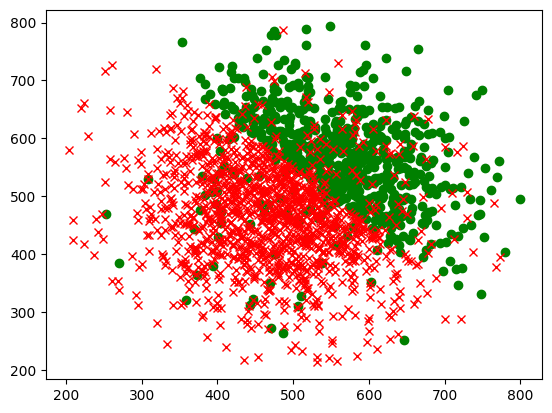

In [119]:
positive = train_y == 1
negative = train_y == 0

plt.plot(train_x[positive, 0], train_x[positive, 1], 'go')
plt.plot(train_x[negative, 0], train_x[negative, 1], 'rx')

## Training the Dataset

**Important** - To get good results we have to do the following:
1. Normalize the training data so that each component of the SAT score ranges from 0 to 1. We can do this by dividing the components by 800. If we do not do this, then our model cannot converge to a minimal cost very well.
2. Divide the training labels and truth labels into 3 groups: training set, cross-validation set and test set. It will be random, but 33% of the size of the data is allocated for cross validation and test in total.

Our model will be a dense neural network with 3 layers:
* 4 unit dense layer with relu activation
* 2 unit dense layer with relu activation
* 1 unit output dense layer with sigmoid activation

We compile the model using `BinaryCrossentropy` because we are just classifying the result in to 2 categories. Our learning rate is 0.001 using the `Adam` optimizer.

Once we decide to train the model using `model.fit`, we will ensure to pass in the _cross-validation_ data was the validation data so that we do not train our model to the point where it will do good on the _test set_. 

We also train with batch size of 8 and for 100 EPOCHs. 

In [121]:
train_x_norm = train_x / 800

In [123]:
x_train, x_rest, y_train, y_rest = train_test_split(train_x_norm, train_y, test_size=0.33)
x_test, x_cross, y_test, y_cross = train_test_split(x_rest, y_rest, test_size=0.50)

model = keras.Sequential(layers=[
    keras.layers.Dense(units=4, activation='relu', input_shape=(2, )),
    keras.layers.Dense(units=2, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid')
])

model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

model.fit(x_train, y_train, validation_data=(x_cross, y_cross), epochs=100, batch_size=8, shuffle=True, verbose=2)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 4)                 12        
                                                                 
 dense_52 (Dense)            (None, 2)                 10        
                                                                 
 dense_53 (Dense)            (None, 1)                 3         
                                                                 
Total params: 25 (100.00 Byte)
Trainable params: 25 (100.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
167/167 - 1s - loss: 0.6918 - accuracy: 0.5277 - val_loss: 0.6772 - val_accuracy: 0.6778 - 964ms/epoch - 6ms/step
Epoch 2/100
167/167 - 0s - loss: 0.6697 - accuracy: 0.6634 - val_loss: 0.6609 - val_accuracy: 0.6778 - 214ms/epoch - 1ms/step
Epoch 3/100
167/167 - 0s - lo

## Test the Model

Now that we have trained the model, we can test to see how good our model is by comparing, in `y_test` our prediction value for that corresponding truth value. We mark an exact prediction with ✅ while something our model got wrong is marked with ❌. 

We also print out the test score too for reference.

In [125]:
# Testing it all...
predictions = model.predict(x_test)

num_scores, _ = x_test.shape

good_result = '✅'
bad_result = '❌'

count_good = 0
for i in range(num_scores):
    y = y_test[i]
    y_hat = 1 if predictions[i] >= 0.5 else 0
    count_good += (1 if y == y_hat else 0)
    print(x_test[i] * 800, 'y_hat', y_hat, 'y', y, good_result if y == y_hat else bad_result)

print("----------------------------------")
print((count_good / num_scores) * 100, "percent accuracy.")

11/11 [==============================] - 0s 840us/step
[516.46348535 321.41079325] y_hat 0 y 0 ✅
[481.48084154 455.66800844] y_hat 0 y 0 ✅
[515.69048106 354.67623482] y_hat 0 y 0 ✅
[647.67524043 524.84474725] y_hat 1 y 0 ❌
[456.59381794 519.91105113] y_hat 0 y 0 ✅
[480.21097749 611.41564756] y_hat 1 y 1 ✅
[519.49456266 449.02794233] y_hat 0 y 0 ✅
[603.49634593 568.07191683] y_hat 1 y 1 ✅
[310.8089062  481.74824516] y_hat 0 y 0 ✅
[739.14281652 567.60070359] y_hat 1 y 1 ✅
[456.77617545 486.33814436] y_hat 0 y 1 ❌
[622.36958895 631.33202609] y_hat 1 y 0 ❌
[540.83503763 561.61753062] y_hat 1 y 1 ✅
[487.65399932 560.18856549] y_hat 0 y 0 ✅
[558.47109195 490.84485216] y_hat 0 y 1 ❌
[396.420296   492.10762136] y_hat 0 y 0 ✅
[464.39619155 295.01641517] y_hat 0 y 0 ✅
[385.60536604 606.44098216] y_hat 0 y 0 ✅
[670.31938297 454.31848201] y_hat 1 y 1 ✅
[419.2029439  724.63424019] y_hat 1 y 1 ✅
[545.57333976 472.77567884] y_hat 0 y 0 ✅
[498.67086096 499.55698416] y_hat 0 y 0 ✅
[457.94999971 681.263

## Use it!

Now you can use it to predict your own score! We define `test_predict` to be used. It takes in 2 arguments: language score, `l` and math score `m`. 

Tweak `LANGUAGE_SCORE` and `MATH_SCORE` to see what you get!!!

In [126]:
def test_predict(l, m):
    college_bound_predict = model.predict(x=[[l / 800, m / 800]])
    is_college_bound = 1 if college_bound_predict[0, 0] >= 0.5 else 0
    
    if is_college_bound == 1:
        print("You are going to a good University! 🎉🥳🎉 🏫")
    else:
        print("Try harder! Study, study, study! 📚📚📚")

In [130]:
LANGUAGE_SCORE = 300
MATH_SCORE = 750

test_predict(LANGUAGE_SCORE, MATH_SCORE)

1/1 [==============================] - 0s 32ms/step
Try harder! Study, study, study! 📚📚📚
